In [2]:
import snap
import sys, os
from collections import defaultdict
import itertools
import numpy as np
import matplotlib.pyplot as plt

from igraph import *
import leidenalg

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Constants

In [3]:
comment_dir = 'data/comments/'

subreddit_name_file = 'data/subredditIdToName'

filtered_users_file = 'data/filteredUsers'
filtered_subreddit_ids_file = 'data/filteredSubreddits'

user_node_ids_file = 'data/user_node_ids.npy'
subreddit_node_ids_file = 'data/subreddit_node_ids.npy'

train_comment_graph_file = 'data/train_comment_graph.txt'
train_comment_igraph_file = 'data/train_comment_igraph.txt'

test_comment_graph_file = 'data/test_comment_graph.txt'
test_comment_igraph_file = 'data/test_comment_igraph.txt'

train_subreddit_graph_file = 'data/train_subreddit_graph.txt'
test_subreddit_graph_file = 'data/test_subreddit_graph.txt'

## Load Data Structures

In [4]:
##############################################
# Load Raw Reddit Data
##############################################
def read_subreddit_names(filename):
    """
    Reads in file with global mappings from subreddit ids to names.
    Filters out subreddit names that begin with 'u_'.

    Examples: [subreddit_id subreddit_name]
        ...
        t5_3m6wn hormuz
        t5_bx9mz u_Ubiver
        ...

    Returns a dictionary mapping from id to name and a set of
    unique subreddit ids.
    """
    subreddit_name_dict = {} # id -> subreddit
    with open(filename) as f:
        for line in f:
            subreddit_id, subreddit_name = line.split()
            if subreddit_name.startswith('u_'): # not subreddit!
                continue
            subreddit_name_dict[subreddit_id] = subreddit_name
    return subreddit_name_dict

def read_filtered_users(filename):
    """
    """
    filtered_users = set() 
    with open(filename) as f:
        for line in f:
            user = line.strip()
            filtered_users.add(user)
    return filtered_users

def read_filtered_subreddit_ids(filename):
    """
    """
    filtered_subredit_ids = set() 
    with open(filename) as f:
        for line in f:
            subreddit_id = line.strip()
            filtered_subredit_ids.add(subreddit_id)
    return filtered_subredit_ids

def read_subreddit_comments(dirname, subreddit_name_dict, filtered_users=None, filtered_subreddit_ids=None, target_months=None):
    """
    Reads in files containing user-subreddit commenting counts. Each file
    name is of the format RC_YYYY-MM where YYYY and MM are year and month,
    respectively.

    Examples: [user subreddit_id comment_count]
        ...
        PGHContrarian68 t5_2ve45 4
        TheIncompetenceOfMan t5_2qh33 11
        ...

    Each edge is represented as (user, subreddit_id) and is weighted by
    the cumulative number of comments by the user on the subreddit.
    Note we only consider edges with existing subreddit_ids.

    Returns dictionary containing edges weighted by comments and
    and a set of unique users.
    """
    # Nodes
    users = set() # unique users 
    subreddits_ids = set() # unique subreddit ids
    
    # Edge set and weights
    comment_edges = set() # unique comment (user, subreddit_id) edges
    comment_weights = defaultdict(int) # edge (user, subreddit_id) -> comment_count
    
    # Edge dictionaries
    user_subreddit_dict = defaultdict(set) # user -> set(subreddit_ids)
    subreddit_user_dict = defaultdict(set) # subreddit_id -> set(users)
    
    for foldername, subdirlist, filelist in os.walk(dirname, topdown=False):
        for fname in sorted(filelist):
            if fname.startswith('RC_'): # formated as RC_YYYY-MM
                # Parse filename for date information
                _, yyyymm = fname.split('_')
                yyyy, mm = yyyymm.split('-')
                                
                # Only parse target months
                if target_months is not None and mm not in target_months:
                    continue
                    
                month_users = set()
                month_subreddit_ids = set()
                month_comment_edges = set()

                # Parse the file for edge weights
                with open(os.path.join(dirname, fname)) as f:
                    for line in f:
                        user, subreddit_id, comment_count = line.split() # e.g. kittykapow925, t5_2yrq6, 1
                        
                        # Skip filtered users and subreddit_ids
                        if filtered_users is not None and user in filtered_users: 
                            continue
                        if filtered_subreddit_ids is not None and subreddit_id in filtered_subreddit_ids:
                            continue
                        
                        # Skip non-existent subreddit_ids
                        if subreddit_id not in subreddit_name_dict: 
                            continue
                            
                        month_users.add(user)
                        month_subreddit_ids.add(subreddit_id)
                        month_comment_edges.add((user, subreddit_id))
                        
                        comment_weights[(user, subreddit_id)] += int(comment_count)
                        user_subreddit_dict[user].add(subreddit_id)
                        subreddit_user_dict[subreddit_id].add(user)
                
                print "Done processing file: ", fname
                
                # Print statistics about new nodes and edges
                new_users = month_users.difference(users)
                new_subreddits_ids = month_subreddit_ids.difference(subreddits_ids)
                new_comment_edges = month_comment_edges.difference(comment_edges)
                
                print "- Number of new users %s / %s" % (len(new_users), len(month_users)) 
                print "- Number of new subreddits %s / %s" % (len(new_subreddits_ids), len(month_subreddit_ids)) 
                print "- Number of new comment interactions %s / %s" % (len(new_comment_edges), len(month_comment_edges)) 
                
                # Merge sets together
                users = users.union(month_users)
                subreddits_ids = subreddits_ids.union(month_subreddit_ids)
                comment_edges = comment_edges.union(month_comment_edges)
    return comment_weights, comment_edges, users, subreddits_ids, user_subreddit_dict, subreddit_user_dict

In [5]:
subreddit_name_dict = read_subreddit_names(subreddit_name_file) # subreddit_id -> subreddit

print "Done processing subreddit name dictionary."

Done processing subreddit name dictionary.


In [6]:
filtered_users = read_filtered_users(filtered_users_file)
filtered_subreddit_ids = read_filtered_subreddit_ids(filtered_subreddit_ids_file)

print "Number of users to filter: ", len(filtered_users) 
print "Number of subreddits to filter: ", len(filtered_subreddit_ids) 

Number of users to filter:  5586566
Number of subreddits to filter:  98959


In [7]:
# Load node_id mappings from disk for all 6 months
user_node_ids = np.load(user_node_ids_file).item() # user -> user_node_id
subreddit_node_ids = np.load(subreddit_node_ids_file).item() # subreddit_id -> subreddit_node_id

print "Number of users_node_ids: ", len(user_node_ids)
print "Number of subreddit_node_ids: ", len(subreddit_node_ids)

Number of users_node_ids:  9731646
Number of subreddit_node_ids:  162242


### Load Filtered Train Set (5-Months)

In [7]:
TRAIN_MONTHS = ['01', '02', '03', '04', '05'] 

train_comment_weights, train_comment_edges, train_users, train_subreddit_ids, train_user_subreddit_dict, train_subreddit_user_dict = read_subreddit_comments(comment_dir, subreddit_name_dict, filtered_users=filtered_users, filtered_subreddit_ids=filtered_subreddit_ids, target_months=TRAIN_MONTHS)

print "TRAIN: Number of unique users: ", len(train_users)
print "TRAIN: Number of unique subreddits: ", len(train_subreddit_ids)
print "TRAIN: Number of unique comment edges: ", len(train_comment_edges)

Done processing file:  RC_2018-01
- Number of new users 2535254 / 2535254
- Number of new subreddits 44961 / 44961
- Number of new comment interactions 14999948 / 14999948
Done processing file:  RC_2018-02
- Number of new users 365537 / 2595779
- Number of new subreddits 3191 / 45936
- Number of new comment interactions 9682492 / 15054037
Done processing file:  RC_2018-03
- Number of new users 206078 / 2684168
- Number of new subreddits 1830 / 46835
- Number of new comment interactions 9078163 / 16244038
Done processing file:  RC_2018-04
- Number of new users 125226 / 2729598
- Number of new subreddits 1293 / 47264
- Number of new comment interactions 8371083 / 16625917
Done processing file:  RC_2018-05
- Number of new users 57688 / 2707236
- Number of new subreddits 776 / 47259
- Number of new comment interactions 8082335 / 17265784
TRAIN: Number of unique users:  3289783
TRAIN: Number of unique subreddits:  52051
TRAIN: Number of unique comment edges:  50214021


In [10]:
TEST_MONTHS = ['06']

test_comment_weights, test_comment_edges, test_users, test_subreddit_ids, test_user_subreddit_dict, test_subreddit_user_dict = read_subreddit_comments(comment_dir, subreddit_name_dict, filtered_users=filtered_users, filtered_subreddit_ids=filtered_subreddit_ids, target_months=TEST_MONTHS)

print "TEST: Number of unique users: ", len(test_users)
print "TEST: Number of unique subreddits: ", len(test_subreddit_ids)
print "TEST: Number of unique comment edges: ", len(test_comment_edges)

Done processing file:  RC_2018-06
- Number of new users 3311010 / 3311010
- Number of new subreddits 55928 / 55928
- Number of new comment interactions 17327567 / 17327567
TEST: Number of unique users:  3311010
TEST: Number of unique subreddits:  55928
TEST: Number of unique comment edges:  17327567


In [8]:
C_train = Graph.Read_Ncol(train_comment_igraph_file, directed=False)

In [9]:
summary(C_train)

IGRAPH UN-- 3341834 50214021 -- 
+ attr: name (v)


In [10]:
C_test = Graph.Read_Ncol(test_comment_igraph_file, directed=False)

In [11]:
summary(C_test)

IGRAPH UN-- 3366938 17327567 -- 
+ attr: name (v)


In [12]:
C_train_part = leidenalg.find_partition(C_train, leidenalg.ModularityVertexPartition)

In [22]:
C_test_part = leidenalg.find_partition(C_test, leidenalg.ModularityVertexPartition)

In [21]:
# # png ('train_comment_partitions.png ', width = 1600 , height=900)
# plot(C_train_part)

In [15]:
print [len(part) for part in C_train_part]

[749983, 734174, 542768, 326004, 289928, 231502, 173081, 171870, 110851, 11057, 492, 67, 30, 25, 2]


In [8]:
def construct_subreddit_graph(users, subreddit_ids, user_node_ids, subreddit_node_ids, user_subreddit_dict):
    # S = snap.PUNGraph.New()
    subreddit_graph_edges = set()
    subreddit_graph_weights = defaultdict(int) # node_id -> weight
    
    # Add subreddit node ids
    # for subreddit_id in subreddit_ids:
    #     S.AddNode(subreddit_node_ids[subreddit_id])

    # Add edges between subreddits
    for i, user in enumerate(users):
        # Get users for subreddit
        projected_subreddits = user_subreddit_dict[user]
        
        # At least two subreddit share this user
        if len(projected_subreddits) >= 2:
            subreddit_pairs = list(itertools.combinations(projected_subreddits, 2))
            for first_subreddit, second_subreddit in subreddit_pairs:
                subreddit_node_ids_ordered = sorted([subreddit_node_ids[first_subreddit], subreddit_node_ids[second_subreddit]])
                first_subreddit_id, second_subreddit_id = subreddit_node_ids_ordered[0], subreddit_node_ids_ordered[1]
                
                subreddit_graph_weights[(first_subreddit_id, second_subreddit_id)] += 1
                subreddit_graph_edges.add((first_subreddit_id, second_subreddit_id))
                
                # S.AddEdge(first_subreddit_id, second_subreddit_id)

        if i % 10000 == 0:
            print "Processed %s / %s users" % (i , len(users))

    return subreddit_graph_edges, subreddit_graph_weights

In [9]:
S_train_edges, S_train_weights = construct_subreddit_graph(train_users, train_subreddit_ids, user_node_ids, subreddit_node_ids, train_user_subreddit_dict)

Processed 0 / 3289783 users
Processed 10000 / 3289783 users
Processed 20000 / 3289783 users
Processed 30000 / 3289783 users
Processed 40000 / 3289783 users
Processed 50000 / 3289783 users
Processed 60000 / 3289783 users
Processed 70000 / 3289783 users
Processed 80000 / 3289783 users
Processed 90000 / 3289783 users
Processed 100000 / 3289783 users
Processed 110000 / 3289783 users
Processed 120000 / 3289783 users
Processed 130000 / 3289783 users
Processed 140000 / 3289783 users
Processed 150000 / 3289783 users
Processed 160000 / 3289783 users
Processed 170000 / 3289783 users
Processed 180000 / 3289783 users
Processed 190000 / 3289783 users
Processed 200000 / 3289783 users
Processed 210000 / 3289783 users
Processed 220000 / 3289783 users
Processed 230000 / 3289783 users
Processed 240000 / 3289783 users
Processed 250000 / 3289783 users
Processed 260000 / 3289783 users
Processed 270000 / 3289783 users
Processed 280000 / 3289783 users
Processed 290000 / 3289783 users
Processed 300000 / 32897

Processed 2450000 / 3289783 users
Processed 2460000 / 3289783 users
Processed 2470000 / 3289783 users
Processed 2480000 / 3289783 users
Processed 2490000 / 3289783 users
Processed 2500000 / 3289783 users
Processed 2510000 / 3289783 users
Processed 2520000 / 3289783 users
Processed 2530000 / 3289783 users
Processed 2540000 / 3289783 users
Processed 2550000 / 3289783 users
Processed 2560000 / 3289783 users
Processed 2570000 / 3289783 users
Processed 2580000 / 3289783 users
Processed 2590000 / 3289783 users
Processed 2600000 / 3289783 users
Processed 2610000 / 3289783 users
Processed 2620000 / 3289783 users
Processed 2630000 / 3289783 users
Processed 2640000 / 3289783 users
Processed 2650000 / 3289783 users
Processed 2660000 / 3289783 users
Processed 2670000 / 3289783 users
Processed 2680000 / 3289783 users
Processed 2690000 / 3289783 users
Processed 2700000 / 3289783 users
Processed 2710000 / 3289783 users
Processed 2720000 / 3289783 users
Processed 2730000 / 3289783 users
Processed 2740

In [29]:
S_test_edges, S_test_weights = construct_subreddit_graph(test_users, test_subreddit_ids, user_node_ids, subreddit_node_ids, test_user_subreddit_dict)

Processed 0 / 3311010 users
Processed 10000 / 3311010 users
Processed 20000 / 3311010 users
Processed 30000 / 3311010 users
Processed 40000 / 3311010 users
Processed 50000 / 3311010 users
Processed 60000 / 3311010 users
Processed 70000 / 3311010 users
Processed 80000 / 3311010 users
Processed 90000 / 3311010 users
Processed 100000 / 3311010 users
Processed 110000 / 3311010 users
Processed 120000 / 3311010 users
Processed 130000 / 3311010 users
Processed 140000 / 3311010 users
Processed 150000 / 3311010 users
Processed 160000 / 3311010 users
Processed 170000 / 3311010 users
Processed 180000 / 3311010 users
Processed 190000 / 3311010 users
Processed 200000 / 3311010 users
Processed 210000 / 3311010 users
Processed 220000 / 3311010 users
Processed 230000 / 3311010 users
Processed 240000 / 3311010 users
Processed 250000 / 3311010 users
Processed 260000 / 3311010 users
Processed 270000 / 3311010 users
Processed 280000 / 3311010 users
Processed 290000 / 3311010 users
Processed 300000 / 33110

Processed 2450000 / 3311010 users
Processed 2460000 / 3311010 users
Processed 2470000 / 3311010 users
Processed 2480000 / 3311010 users
Processed 2490000 / 3311010 users
Processed 2500000 / 3311010 users
Processed 2510000 / 3311010 users
Processed 2520000 / 3311010 users
Processed 2530000 / 3311010 users
Processed 2540000 / 3311010 users
Processed 2550000 / 3311010 users
Processed 2560000 / 3311010 users
Processed 2570000 / 3311010 users
Processed 2580000 / 3311010 users
Processed 2590000 / 3311010 users
Processed 2600000 / 3311010 users
Processed 2610000 / 3311010 users
Processed 2620000 / 3311010 users
Processed 2630000 / 3311010 users
Processed 2640000 / 3311010 users
Processed 2650000 / 3311010 users
Processed 2660000 / 3311010 users
Processed 2670000 / 3311010 users
Processed 2680000 / 3311010 users
Processed 2690000 / 3311010 users
Processed 2700000 / 3311010 users
Processed 2710000 / 3311010 users
Processed 2720000 / 3311010 users
Processed 2730000 / 3311010 users
Processed 2740

In [ ]:
# S_train_cluster_coeff = snap.GetClustCf(S_train, 100)
# S_test_cluster_coeff = snap.GetClustCf(S_test, 100)


# print "S_train: Number of nodes: ", S_train.GetNodes()
# print "S_train: Number of edges: ", S_train.GetEdges()
# print "S_train: Clustering Coefficient: ", S_train_cluster_coeff

# print "S_test: Number of nodes: ", S_test.GetNodes()
# print "S_test: Number of edges: ", S_test.GetEdges()
# print "S_test: Clustering Coefficient: ", S_test_cluster_coeff

In [ ]:
# snap.SaveEdgeList(S_train_edges, train_subreddit_graph_file) # save graph to text file

In [ ]:
# snap.SaveEdgeList(S_test_edges, test_subreddit_graph_file) # save graph to text file

In [9]:
train_subreddit_graph_weights_file = 'data/train_subreddit_graph_weights.txt'
test_subreddit_graph_weights_file = 'data/test_subreddit_graph_weights.txt'

# np.save(train_subreddit_graph_weights_file, S_train_weights) 
# np.save(test_subreddit_graph_weights_file, S_test_weights) 

In [10]:
train_subreddit_igraph_edgelist_file = 'data/train_subreddit_igraph_edgelist.txt'
test_subreddit_igraph_edgelist_file = 'data/test_subreddit_igraph_edgelist.txt'

# with open(train_subreddit_igraph_edgelist_file, 'w') as f:
# #     lines = []
# #     for edge, weight in S_train_weights.iteritems():
# #         subreddit_node_id_1, subreddit_node_id_2 = edge
        
# #         line = ' '.join([str(subreddit_node_id_1), str(subreddit_node_id_2), str(weight)])
# #         lines.append(line)
#     f.write('\n'.join(lines))
    

In [11]:
S_train = Graph.Read_Ncol(train_subreddit_igraph_edgelist_file, weights="if_present", directed=False)

In [12]:
summary(S_train)

IGRAPH UNW- 52050 384663141 -- 
+ attr: name (v), weight (e)


In [69]:
summary(S_train)

IGRAPH UNW- 52050 384663141 -- 
+ attr: name (v), weight (e)


In [68]:
train_subreddit_graphml_file = 'data/train_subreddit_graphml.graphml'

Graph.write(S_train, train_subreddit_graphml_file, "graphml")

In [72]:
S_train_part_modularity = leidenalg.find_partition(S_train, 
                                        leidenalg.ModularityVertexPartition, 
                                        weights='weight')
print "Modularity: Number of detected communities: ", len(S_train_part_modularity)

Modularity: Number of detected communities:  6


In [74]:
print [len(part) for part in S_train_part_modularity]

[36837, 13123, 2071, 10, 5, 4]


In [53]:
"""
A higher resolution parameter results in more (smaller) communities. 
A lower resolution parameter results in less (larger) communities.
"""
S_train_part_rbconfig = leidenalg.find_partition(S_train, 
                                                 leidenalg.RBConfigurationVertexPartition,
                                                 weights='weight', 
                                                 resolution_parameter=8.0)
print "RBConfig: Number of detected communities: ", len(S_train_part_rbconfig)

RBConfig: Number of detected communities:  7256


In [66]:
print [len(part) for part in S_train_part_rbconfig]

[2536, 2402, 1880, 1747, 1376, 1370, 1282, 1182, 892, 854, 660, 654, 614, 362, 362, 349, 311, 305, 279, 267, 250, 244, 235, 228, 226, 209, 207, 183, 182, 171, 171, 165, 161, 159, 155, 150, 150, 148, 147, 143, 141, 128, 121, 116, 111, 110, 109, 109, 100, 99, 98, 97, 96, 93, 92, 88, 87, 83, 82, 82, 81, 81, 80, 80, 78, 78, 77, 76, 75, 75, 75, 73, 73, 73, 73, 70, 70, 69, 69, 69, 67, 66, 66, 66, 65, 65, 65, 64, 63, 62, 62, 61, 61, 61, 59, 59, 58, 58, 57, 57, 56, 56, 55, 55, 54, 53, 53, 53, 52, 52, 52, 52, 52, 52, 51, 51, 51, 51, 50, 50, 50, 50, 50, 48, 48, 48, 48, 48, 47, 47, 46, 45, 45, 45, 45, 44, 44, 44, 44, 44, 44, 43, 43, 43, 42, 42, 42, 42, 41, 41, 41, 40, 40, 40, 40, 40, 39, 39, 39, 39, 39, 39, 39, 38, 38, 38, 38, 38, 38, 37, 37, 36, 36, 36, 36, 35, 35, 35, 35, 35, 35, 34, 34, 34, 34, 34, 34, 34, 33, 33, 33, 33, 33, 33, 33, 33, 33, 32, 32, 32, 32, 32, 32, 32, 31, 31, 31, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 29, 29, 29, 29, 29, 29, 29, 29, 29, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28

In [89]:
print [subreddit_name_dict[inv_subreddit_node_ids[int(S_train.vs[i]["name"])]] for i in S_train_part_rbconfig[50]]

['StalkerStories', 'TapBusters', 'BrockhamptonToThe', 'dataengineering', 'NISTControls', 'dividend_investing', 'dakboard', 'IndyCarPorn', 'Dads', 'learnwebdev', 'comedians', 'unh', 'ozora', 'OPCoin_official', 'moneyrebel', 'MCVanillaServers', 'Thor', 'drywall', 'mechatronics', 'Ethnobotany', 'racinggames', 'dreadrpg', 'philosophyself', 'HomeAudio', 'CSLewis', 'customyugioh', 'RevolutionRealized', 'pokemon_lets_go', 'Dream', 'boone', 'VolcanoVaporizer', 'keys', 'softsynths', 'footballmanager', 'PADI', 'RCVendorCheck', 'AskOccult', 'shittyELI5', 'scrapclicker', 'ASRock', 'OnyxPathRPG', 'HuaweiP9', 'HistoryPodcast', 'linuxdev', 'Relationship', 'Fayettenam', 'TicPods', 'ChristianUniversalism', 'FordEdge', 'oldnorse', 'AdNauseamMTG', 'TheBibleReloaded', 'CoD4Promod', 'datahorder', 'cheatingrevenge', 'BushcraftUK', 'LuckchemyTeam', 'FirefoxAddons', 'juridischadvies', 'entomophagy', 'MySexConfession', 'clonewars', 'cronometer', 'funorb', 'BJD', 'CanIRunIt', 'BreastPumps', 'ChildrenOfTheLight'

In [56]:
"""
A higher resolution parameter results in more (smaller) communities. 
A lower resolution parameter results in less (larger) communities.
"""
S_train_part_rber= leidenalg.find_partition(S_train, 
                                                 leidenalg.RBERVertexPartition,
                                                 weights='weight', 
                                                 resolution_parameter=2.0)
print "RBER: Number of detected communities: ", len(S_train_part_rber)

RBER: Number of detected communities:  26633


In [58]:
print [len(part) for part in S_train_part_rber]

[13414, 187, 159, 151, 140, 132, 116, 116, 103, 81, 79, 78, 68, 66, 66, 63, 62, 59, 58, 58, 53, 53, 53, 52, 46, 43, 43, 41, 40, 39, 37, 37, 37, 36, 35, 34, 34, 33, 29, 29, 28, 28, 27, 27, 25, 25, 24, 24, 24, 23, 23, 22, 22, 21, 21, 21, 20, 20, 19, 19, 18, 18, 18, 18, 18, 17, 17, 17, 17, 17, 17, 17, 17, 16, 16, 16, 16, 16, 16, 16, 15, 15, 15, 15, 14, 14, 14, 14, 14, 14, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 

In [88]:
print [subreddit_name_dict[inv_subreddit_node_ids[int(S_train.vs[i]["name"])]] for i in S_train_part_rber[50]]

['privatix', 'highvoltage', 'Globaljobcoin', 'CashBet', 'HEROcoin', 'Photon', 'fundyourselfnow', 'MAVRO_ORG', 'MicroMoney', 'PlusCoin', 'PlayMXM', 'ZeroCoin', 'BitRent', 'footycash', 'universe', 'halcyon6', 'carboncoinofficial', 'digitalcoin', 'Digipulse', 'GaiaGPS', 'MinCoin', 'Tigereum', 'sagacrypto']


In [45]:
# NOTE: No resolution_parameter to tune :(
S_train_part_surprise = leidenalg.find_partition(S_train, 
                                                 leidenalg.SurpriseVertexPartition,
                                                 weights='weight')
print "Surprise: Number of detected communities: ", len(S_train_part_surprise)

Surprise: Number of detected communities:  46601


In [55]:
S_train_part_cpm = leidenalg.find_partition(S_train, 
                                            leidenalg.CPMVertexPartition,
                                            weights='weight',
                                            resolution_parameter=5.0)
print "CPM: Number of detected communities: ", len(S_train_part_cpm)

CPM: Number of detected communities:  34014


In [64]:
print [len(part) for part in S_train_part_cpm]

[9811, 149, 138, 133, 131, 120, 107, 57, 51, 49, 40, 29, 28, 28, 27, 26, 25, 25, 25, 24, 21, 21, 21, 21, 19, 17, 17, 16, 16, 16, 16, 16, 15, 15, 15, 15, 15, 15, 14, 14, 14, 14, 13, 13, 13, 13, 13, 13, 13, 13, 13, 12, 12, 12, 12, 12, 11, 11, 11, 11, 11, 11, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

In [27]:
inv_subreddit_node_ids = {node_id: node for node, node_id in subreddit_node_ids.iteritems()}

In [50]:
print [subreddit_name_dict[inv_subreddit_node_ids[int(S_train.vs[i]["name"])]] for i in S_train_part_cpm[2]]

['ancientanatolia', 'whatwouldyoudo', 'Android_TV', 'Development', 'biketouring', 'pdxkbc', 'GiftCardTrading', 'MaddenGMs', 'YoutubeFunnyVideos', 'OtcritPlatform', 'Tello', 'ycombinator', 'kungfupanda', 'ShortSadStories', 'xrptrader', 'bajiquan', 'MedicalHelp', 'IoTeX', 'starpointgemini', 'xbmc', 'bitcoins', 'Antediluvia', 'VelcroBabies', 'HealthConspiracy', 'IndivisibleGuide', 'Ohiogirl1988', 'aromatherapy', 'Jarvee', 'shitty_confessions', 'carmods', 'HeroUnlocker', 'contracts', 'Thinwomen', 'Adel', 'avionics', '8bit', 'Vilnius', 'royceda59', 'YieldCoin', 'CelebMilfs', 'SubsThatHaveBannedMe', 'BPD_Aftermath', 'pornfordykes', 'ProjectSTARGATE', 'seattler4r', 'NeedLyrics', 'CollegeAdmissions', 'Soundbars', 'The_Crypto', 'WeARGames', 'learnblender', 'Stoner', 'UKProperty', 'mspjobs', 'CMH', 'OCR', 'Battlefield__1', 'satire_de_en', 'Zowie', 'UKBBQ', 'AskLegal', 'Chatpals', 'TXRenaissanceFestival', 'Mythras', 'Jeff', 'Earphones', 'UtahRiders', 'Solarwinds', 'andnowmyrewatchbegins', 'Existe

In [36]:
print [subreddit_name_dict[inv_subreddit_node_ids[int(S_train.vs[i]["name"])]] for i in S_train_part[1]]

['Speedcore', 'firstworldanarchists', 'space', 'behindthegifs', 'Rabbits', 'starterpacks', 'creepy', 'firstmarathon', 'iphone', 'GreenBayPackers', 'powerwashingporn', 'geopolitics', 'shavian', 'OutOfTheLoop', 'AdviceAnimals', 'howto', 'cringe', 'tranceproduction', 'youseeingthisshit', 'socialism', 'google', 'UpvotedBecauseGirl', 'Jaguars', 'LosAngeles', 'StreetFights', 'needadvice', 'hiddenrooms', 'electronicmusic', 'SiliconValleyHBO', 'AbsoluteUnits', 'dashcamgifs', 'Roadcam', 'lossedits', 'renderings', 'Libertarian', 'exchristian', 'killthosewhodisagree', 'TopGear', 'mycology', 'Flipping', 'sex', 'gamegrumps', 'darksouls', 'Fallout', 'torrents', 'lakers', 'tacobell', 'Piracy', 'halloween', 'factorio', 'pokemongo', 'BMW', 'xboxone', 'GamingDetails', 'Cartalk', 'shittydarksouls', 'Kanye', 'whatisthisthing', 'Colorado', 'buildapc', 'AnimalsBeingDerps', 'disney', 'ECW', 'EmpireDidNothingWrong', 'math', 'MadeMeSmile', 'ScenesFromAHat', 'ShitRedditSays', 'olling', 'perfectloops', '4chan', 

In [30]:
print [subreddit_name_dict[inv_subreddit_node_ids[int(S_train.vs[i]["name"])]] for i in S_train_part[2]]

['Iron', 'Innie', 'MassiveCock', 'rimming', 'Graphis', 'CelestiaVega', 'braceface', 'stupidslutsclub', 'randomsexiness', 'freeuse', 'downblouse', 'gwcumsluts', 'deepthroat', 'LingerieGW', 'CrossfitHotwife', 'OnStageGW', 'pm_your_pokemon_team', 'pawg', 'gonewildcouples', 'nsfwoutfits', 'nsfwcosplay', 'HappyEmbarrassedGirls', 'skankhunt100188', 'NattiMaretta', 'analgonewild', 'HighResNSFW', 'RealGirls', 'feet', 'CuteLittleButts', 'nsfw_wtf', 'exotic_oasis', 'RepressedGoneWild', 'GirlsFinishingTheJob', 'AmateurSlutWives', 'PreggoPorn', 'NSFWBraids', 'gonewildcurvy', 'showerbeer', 'Upskirt', 'JustOneBoob', 'yokoblue', 'chubby', 'ImagesOfBrazil', 'gonewildchubby', 'bikinibridge', '18_19', 'dykesgonewild', 'creamytaiwan', 'Blonde', 'LegsGW', 'BeautifullyBare', 'SouthFloridaSluts', 'wifesharing', 'SexInFrontOfOthers', 'Stacked', 'dirtyr4r', 'sophiehoward', 'lingerie', 'snapchatgw', 'JizzedToThis', 'JacquelineDevries', 'TinyTits', 'hugeboobs', 'onmww', 'Carli3', 'blackchickswhitedicks', 'petit

In [31]:
print [subreddit_name_dict[inv_subreddit_node_ids[int(S_train.vs[i]["name"])]] for i in S_train_part[3]]

['UnitedStatesOfReddit', 'HongKongMusic', 'JapanCulture', 'paidX_ICO', 'germanystudy', 'Indiacryptocurrency', 'NetherlandsWorldCup', 'GoldenStateWarriors', 'FranceWorld', 'DubaiExpo2020', 'UnitedStatesArmy']


In [32]:
print [subreddit_name_dict[inv_subreddit_node_ids[int(S_train.vs[i]["name"])]] for i in S_train_part[4]]

['howtovid', 'namegood', 'interestingcollect', 'bestcollect', 'goodguide', 'famelink', 'thegoodthings', 'goodforme', 'bestuse', 'usefullinks']


In [33]:
print [subreddit_name_dict[inv_subreddit_node_ids[int(S_train.vs[i]["name"])]] for i in S_train_part[5]]

['FraudMarket', 'Fraudforum', 'cardingforums', 'fraudnetreloaded', 'FraudAndScams']


In [34]:
print [subreddit_name_dict[inv_subreddit_node_ids[int(S_train.vs[i]["name"])]] for i in S_train_part[6]]

['DecayingFates', 'DRHeavensVale', 'despairwonderland', 'drinfiniteworld', 'dangancitylights']


In [35]:
print [subreddit_name_dict[inv_subreddit_node_ids[int(S_train.vs[i]["name"])]] for i in S_train_part[7]]

['LightningvsCapitals24', 'SoccerHQ24', 'RocketsvsWarriors9', 'WarriorsvsRocketsHQ']


In [ ]:
def getFilteredDataPointsToPlot(Graph):
    """
    :param - Graph: snap.PUNGraph object representing an undirected graph
    :filtered_nodes - list: list of Node IDs that we want to plot

    return values:
    X: list of degrees
    Y: list of frequencies: Y[i] = fraction of nodes with degree X[i]
    """
    N = len(filtered_nodes) # total number of nodes in graph

    # Get frequency counts of degree
    degreeFreq = {}
    for node_id in filtered_nodes:
        node = G.GetNI(node_id)
        degree = node.GetOutDeg()
        if degree in degreeFreq:
            degreeFreq[degree] += 1
        else:
            degreeFreq[degree] = 1

    X, Y = [], []
    for degree, count in degreeFreq.iteritems():
        count_ratio = float(count) / N
        X.append(degree)
        Y.append(count_ratio)
    return X, Y

x, y = getFilteredDataPointsToPlot(S_train)
plt.loglog(x, y, 'r+', color = 'r', label = 'Subreddit Nodes')

plt.xlabel('Node Degree (log)')
plt.ylabel('Proportion of Nodes with a Given Degree (log)')
plt.title('Degree Distribution of Folded Subreddit Nodes')
plt.legend()
plt.show()

### Training Set Analysis (5-Months)

In [ ]:
def print_subreddit_statistics(comment_weights, comment_edges, users, subreddit_ids, user_subreddit_dict, subreddit_user_dict):
    print "Number of average subreddits per user: ", 1.0 * len(comment_edges) /  len(users)
    total_num_comments = sum(comment_weights.itervalues())
    print "Number of average comments per user: ", 1.0 * total_num_comments /  len(users)

#     subreddit_freq_dict = defaultdict(int)
#     for user, subreddits in user_subreddit_dict.iteritems():
#         subreddit_freq_dict[len(subreddits)] += 1

#     max_subreddit_count = 30
#     subreddit_counts = np.arange(1, max_subreddit_count)
#     num_users = [subreddit_freq_dict[subreddit_count] for subreddit_count in subreddit_counts]
    
#     plt.title("How Many Users Commented on N-Subreddits? (Jan-May)")
#     plt.xlabel("N-Subreddits")
#     plt.ylabel("Number of Users")
#     plt.bar(subreddit_counts, num_users)
#     plt.show()
    
#     # The slices will be ordered and plotted counter-clockwise.
#     labels = [(str(subreddit_count) + " Subreddit(s)") for subreddit_count in subreddit_counts[:15]] + ['16+ Subreddits']# ['Rayos X (88.4 %)', 'RMN en solucion (10.6 %)', 'Microscopia electronica (0.7 %)', 'Otros (0.3 %)']
#     sizes = num_users[:15] + [sum(num_users[15:])] # [88.4, 10.6, 0.7, 0.3]
#     patches, texts = plt.pie(sizes, startangle=90)
#     plt.title("Proportion of Users that Commented on N-Subreddits (Jan-May)")
#     plt.legend(patches, labels, loc="best")
#     # Set aspect ratio to be equal so that pie is drawn as a circle.
#     plt.axis('equal')
#     plt.tight_layout()
#     plt.show()
    
#     print "Top-15 user counts: ", num_users[:max_subreddit_count]
#     print "Percent of users who comment on just 1 Subreddit: ", 100.0 * subreddit_freq_dict[1] / len(users)
#     print "Percent of users who comment on just 1 or 2 Subreddits: ", 100.0 * (subreddit_freq_dict[1] + subreddit_freq_dict[2])/ len(users)
#     print "Percent of users who comment on just 1, 2, or 3 Subreddits: ", 100.0 * (subreddit_freq_dict[1] + subreddit_freq_dict[2] + subreddit_freq_dict[3])/ len(users)
    
#     user_freq_dict = defaultdict(int)
#     for subreddit, users in subreddit_user_dict.iteritems():
#         user_freq_dict[len(users)] += 1
    
#     max_user_count = 30
#     user_counts = np.arange(1, max_user_count)
#     num_subreddits = [user_freq_dict[user_count] for user_count in user_counts]

#     plt.title("How Many Subreddits Had N-Users? (Jan-May)")
#     plt.xlabel("N-Users")
#     plt.ylabel("Number of Subreddits")
#     plt.bar(user_counts, num_subreddits)
#     plt.show()
    
#     # The slices will be ordered and plotted counter-clockwise.
#     labels = [(str(user_count) + " User(s)") for user_count in user_counts[:10]] + ['11+ Users']# ['Rayos X (88.4 %)', 'RMN en solucion (10.6 %)', 'Microscopia electronica (0.7 %)', 'Otros (0.3 %)']
#     sizes = num_subreddits[:10] + [sum(user_counts[10:])] # [88.4, 10.6, 0.7, 0.3]
# #     colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
#     patches, texts = plt.pie(sizes, startangle=90)
#     plt.title("Proportion of Subreddits That Had N-Users (Jan-May)")
#     plt.legend(patches, labels, loc="best")
#     # Set aspect ratio to be equal so that pie is drawn as a circle.
#     plt.axis('equal')
#     plt.tight_layout()
#     plt.show()

In [11]:
print_subreddit_statistics(train_comment_weights, train_comment_edges, train_users, train_subreddit_ids, train_user_subreddit_dict, train_subreddit_user_dict)

Number of average subreddits per user:  15.2636271146
Number of average comments per user:  118.859144205


### Test Statistics: Unseen Nodes and Edges

In [12]:
new_test_users = test_users.difference(train_users)
print "CURRENT: Percent of users unseen: %.1f%% = %s / %s" % (100.0 * len(new_test_users) / len(test_users), len(new_test_users), len(test_users))

new_test_subreddit_ids = test_subreddit_ids.difference(train_subreddit_ids) 
print "CURRENT: Percent of subreddits unseen: %.1f%% = %s / %s" % (100.0 * len(new_test_subreddit_ids) / len(test_subreddit_ids), len(new_test_subreddit_ids), len(test_subreddit_ids))

new_test_comment_edges = test_comment_edges.difference(train_comment_edges)
print "CURRENT: Percent of comment edges unseen: %.1f%% = %s / %s" % (100.0 * len(new_test_comment_edges) / len(test_comment_edges), len(new_test_comment_edges), len(test_comment_edges))

CURRENT: Percent of users unseen: 25.4% = 840809 / 3311010
CURRENT: Percent of subreddits unseen: 18.4% = 10285 / 55928
CURRENT: Percent of comment edges unseen: 45.3% = 7847365 / 17327567


In [13]:
# ##############################################
# # Construct Node and Edge IDs
# ##############################################
# def generate_node_ids(alls_users, all_subreddit_ids):
#     """
#     Generate node ids by assigning each user a consecutive
#     integer value in [0, num_users) and each subreddit
#     a consecutive integer value in [num_users, num_users+num_subreddits)

#     Returns dictionaries of users and subreddit_ids to their corresponding
#     node ids.
#     """
#     num_users = len(alls_users) # = MAX_UID
#     num_subreddits = len(all_subreddit_ids)

#     # Iterate through sorted users
#     user_node_ids = {} # user -> user_node_id
#     users = sorted(alls_users)
#     for user_node_id, user in enumerate(users):
#         user_node_ids[user] = user_node_id

#     # Iterate through sorted subreddit ids
#     subreddit_node_ids = {} # subreddit_id -> subreddit_node_id
#     subreddit_ids = sorted(all_subreddit_ids)
#     for subreddit_node_id, subreddit_id in enumerate(subreddit_ids):
#         subreddit_node_ids[subreddit_id] = num_users + subreddit_node_id # shifted by num_users

#     return user_node_ids, subreddit_node_ids

In [14]:
# user_node_ids, subreddit_node_ids = generate_node_ids(users, subreddit_ids)

In [15]:
# # Save
# np.save(user_node_ids_file, user_node_ids) 
# np.save(subreddit_node_ids_file, subreddit_node_ids) 

## Construct Bipartite User-Subreddit Graph (with Snap)

In [15]:
# def construct_comment_graph(users, subreddit_ids, comment_edges, 
#                             all_user_node_ids, all_subreddit_node_ids):
#     """
#     Creates a the User-Subreddit bipartite undirected graph where the nodes
#     are users and subreddits and the edges between the users and subreddits
#     represent when a user has commented on a subreddit.
#     """
#     # Construct the bipartise graph
#     C = snap.PUNGraph.New()

#     # Add user node ids
#     for user in users:
#         user_node_id = all_user_node_ids[user]
#         C.AddNode(user_node_id)
        
#     print "Done adding user nodes."

#     # Add subreddit node ids
#     for subreddit_id in subreddit_ids:
#         subreddit_node_id = all_subreddit_node_ids[subreddit_id]
#         C.AddNode(subreddit_node_id)
    
#     print "Done adding subreddit nodes."
        
#     # Add comment edges
#     for i, comment_edge in enumerate(comment_edges):
#         user, subreddit_id = comment_edge
#         user_node_id = all_user_node_ids[user]
#         subreddit_node_id = all_subreddit_node_ids[subreddit_id]
#         C.AddEdge(user_node_id, subreddit_node_id)
        
#         if i % 1000000 == 0:
#             print "Processed %s / %s edges" % (i , len(comment_edges))

#     print "Done adding comment edges."

#     return C

In [ ]:
# C_train = construct_comment_graph(train_users, train_subreddit_ids, train_comment_edges, user_node_ids, subreddit_node_ids)

# print "C_train: Number of nodes: ", C_train.GetNodes()
# print "C_train: Number of edges: ", C_train.GetEdges()

Done adding user nodes.
Done adding subreddit nodes.
Processed 0 / 50214021 edges
Processed 1000000 / 50214021 edges
Processed 2000000 / 50214021 edges
Processed 3000000 / 50214021 edges
Processed 4000000 / 50214021 edges
Processed 5000000 / 50214021 edges
Processed 6000000 / 50214021 edges
Processed 7000000 / 50214021 edges
Processed 8000000 / 50214021 edges
Processed 9000000 / 50214021 edges
Processed 10000000 / 50214021 edges
Processed 11000000 / 50214021 edges
Processed 12000000 / 50214021 edges
Processed 13000000 / 50214021 edges
Processed 14000000 / 50214021 edges
Processed 15000000 / 50214021 edges
Processed 16000000 / 50214021 edges
Processed 17000000 / 50214021 edges
Processed 18000000 / 50214021 edges
Processed 19000000 / 50214021 edges
Processed 20000000 / 50214021 edges
Processed 21000000 / 50214021 edges
Processed 22000000 / 50214021 edges
Processed 23000000 / 50214021 edges
Processed 24000000 / 50214021 edges
Processed 25000000 / 50214021 edges
Processed 26000000 / 502140

In [ ]:
# snap.SaveEdgeList(C_train, train_comment_graph_file) # save graph to text file

In [ ]:
# C_test = construct_comment_graph(test_users, test_subreddit_ids, test_comment_edges, user_node_ids, subreddit_node_ids)

In [65]:
# print "C_test: Number of nodes: ", C_test.GetNodes()
# print "C_test: Number of edges: ", C_test.GetEdges()

C_current: Number of nodes:  4788981
C_current: Number of edges:  19691982


In [68]:
# snap.SaveEdgeList(C_test, test_comment_graph_file) # save graph to text file

## Print Basic Statistics about Graph

In [ ]:
# G_cluster_coeff = snap.GetClustCf(G, 1000)
# G_density = float(G.GetEdges()) / (G.GetNodes() * (G.GetNodes() - 1))

# print "Clustering Coefficient: ", G_cluster_coeff
# print "Density: ", G_density

## Plot Degree Distribution Graph

In [22]:
def getFilteredDataPointsToPlot(Graph, filtered_nodes):
    """
    :param - Graph: snap.PUNGraph object representing an undirected graph
    :filtered_nodes - list: list of Node IDs that we want to plot

    return values:
    X: list of degrees
    Y: list of frequencies: Y[i] = fraction of nodes with degree X[i]
    """
    N = len(filtered_nodes) # total number of nodes in graph

    # Get frequency counts of degree
    degreeFreq = {}
    for node_id in filtered_nodes:
        node = G.GetNI(node_id)
        degree = node.GetOutDeg()
        if degree in degreeFreq:
            degreeFreq[degree] += 1
        else:
            degreeFreq[degree] = 1

    X, Y = [], []
    for degree, count in degreeFreq.iteritems():
        count_ratio = float(count) / N
        X.append(degree)
        Y.append(count_ratio)
    return X, Y

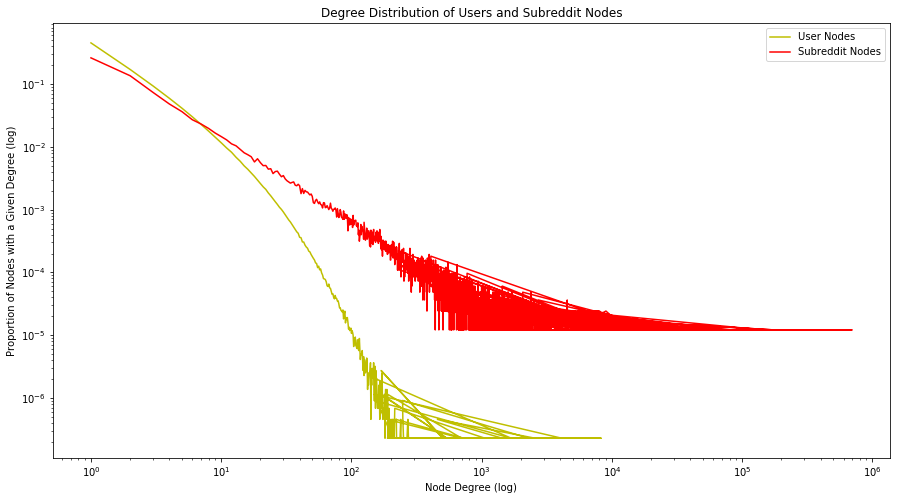

In [21]:
x_user, y_user = getFilteredDataPointsToPlot(G, filtered_nodes=user_node_ids.values())
plt.loglog(x_user, y_user, color = 'y', label = 'User Nodes')

x_subreddit, y_subreddit = getFilteredDataPointsToPlot(G, filtered_nodes=subreddit_node_ids.values())
plt.loglog(x_subreddit, y_subreddit, color = 'r', label = 'Subreddit Nodes')

plt.xlabel('Node Degree (log)')
plt.ylabel('Proportion of Nodes with a Given Degree (log)')
plt.title('Degree Distribution of Users and Subreddit Nodes')
plt.legend()
plt.show()

## Construct User-User Graph (Shared Subreddits)

In [24]:
def construct_user_graph(users, subreddit_ids, user_node_ids, subreddit_node_ids, train_subreddit_user_dict):
    U = snap.PUNGraph.New()

    # Add user node ids
    for user in users:
        U.AddNode(user_node_ids[user])

    # Add edges between users
    for i, subreddit_id in enumerate(subreddit_ids):
        # Get users for subreddit
        projected_users = train_subreddit_user_dict[subreddit_id]
        
        # At least two users share this subreddit
        if len(projected_users) >= 2:
            user_pairs = list(itertools.combinations(projected_users, 2))
            for first_user, second_user in user_pairs:
                U.AddEdge(user_node_ids[first_user], user_node_ids[second_user])
    
        if i % 1000 == 0:
            print "Processed %s / %s subreddits" % (i , len(subreddit_ids))

    return U

In [ ]:
U_train = construct_user_graph(train_users, train_subreddit_ids, user_node_ids, subreddit_node_ids, train_subreddit_user_dict)

Processed 0 / 52051 subreddits


In [ ]:
print "U_train: Number of nodes: ", U_train.GetNodes()
print "U_train: Number of edges: ", U_train.GetEdges()

In [ ]:
U_train_cluster_coeff = snap.GetClustCf(U_train, 100)
print "U_train: Clustering Coefficient: ", U_train_cluster_coeff